This notebook takes in all of the operator features, creates some final ones, and then runs them through an ensemble anomaly detection model. It outputs outlier probabilities for all wallets but also outputs a file of the top candidates for consideration as cheaters. -- Lisa Marshall

In [1]:
import pandas as pd, numpy as np, datetime as dt
import sklearn, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

#data = pd.read_pickle('operatorData.pkl') #from operatorData.ipynb
data = pd.read_pickle('operatorDataTx.pkl') # from mergeTXdata3.ipynb

**Reason to use mahalanobis distance -- by the way, you can use it with highly correlated data (so perhaps include the extra columns
https://medium.com/@ikaya754/anomaly-detection-and-mahalanobis-distance-25b21b7cfe5b#:~:text=Mahalanobis%20distance%20is%20used%20to%20determine%20the%20distance,however%2C%20the%20result%20is%20wrong%20for%20skewed%20data.**

In [2]:
#add average pay per node feature
data['avgPayPerNode']=data.apply(lambda x: x['avgMonthPay']/x['unique_nodes'],axis=1)

In [3]:
#add feature that counts the number of days the node operator has been operational
daysInService = data.apply(lambda x: pd.to_datetime('2021-04-30').date()-x['earliestNodeCreated'],axis=1)
data['daysInService']=daysInService.dt.days

In [4]:
data[data.maxPieceCount==0].loc[2291,:].T

wallet                          0x6ded65b4a912764b26d288bf740ac8e784b8c958
unique_nodes                                                             1
minAuditReputation                                                       1
avgAuditReputation                                                       1
maxAuditReputation                                                       1
minFreeDisk                                                          8e+12
avgFreeDisk                                                          8e+12
maxFreeDisk                                                          8e+12
minPieceCount                                                            0
avgPieceCount                                                            0
maxPieceCount                                                            0
earliestNodeCreated                                             2020-11-28
mostRecentNodeCreated                                           2020-11-28
fullWalletList           

In [5]:
#add avgMonthPay/avgPieceCount
data['relPieceToPay'] = data.apply(lambda x: x['avgPieceCount']/x['avgMonthPay'],axis=1)

In [6]:
#one-hot encode the type column
onehot_types = pd.get_dummies(data['type'], prefix='type')
data = data.drop('type',axis=1).merge(onehot_types,left_index=True, right_index=True)

In [7]:
#include a column that reflects shift in payments from Feb to March
data['marchShift']=data['2021-03-01']-data['2021-02-01']
#include proportions of unique in- and out-bound transactions to their totals
data['uniqOutboundProp'] = data.apply(lambda x: x['uniqueOutbound']/x['numOutbound'] if x['numOutbound']>0 else 0,axis=1)
data['uniqInboundProp'] = data.apply(lambda x: x['uniqueInbound']/x['numInbound'] if x['numInbound']>0 else 0, axis=1)

**subset, standardize, and normalize data**
DBSCAN and LOF don't work well at higher dimension (>20). When I tried using DBSCAN on the full 25-feature set (cols1 below), it found more noise than signal, so the results weren't usable. 
So for DBSCAN and LOF, I have a subset of our subset (cols2) that uses only 17 features.

In [8]:
cols1 = ['wallet', 'unique_nodes', 'avgAuditReputation',
       'avgFreeDisk', 'maxPieceCount', 
       'numAssocWallets', 'numAssocEmails',
       'avgMonthPay',  'numOutbound','tokenTypes',
       'numInbound','numAssoc', 'marchShift',
       'uniqOutboundProp', 'uniqInboundProp','avgPayPerNode', 'daysInService','relPieceToPay']

cols2 = []

In [9]:
data = data.reset_index(drop=True)
X = data[cols1]
#Xsub = data[cols2]

In [10]:
# Scaling the data to make sure no extreme values exert undue influence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.iloc[:,1:])
#Xsub_scaled = scaler.fit_transform(Xsub.iloc[:,1:])

In [11]:
#Force into normal distribution
X_normalized = normalize(X_scaled)
#Xsub_normalized = normalize(Xsub_scaled)

In [12]:
#convert back to dataframe
X_normalized = pd.DataFrame(X_normalized)
#Xsub_normalized = pd.DataFrame(Xsub_normalized)

In [13]:
#create separate adjuster function for algos form the pyod package, where anomalies are marked 1 instead of -1
#here, any anomaly that doesn't meet the threshold gets assigned -1
def adjusterPyod(x,outputCol):
    if x[outputCol] != 1:
        return 0
    elif ((x[7]>20) or (x[7]>10 and x[11]>0)):
        return 1
    else:
        return -1

**Ensemble**

In [14]:
def runModels(ensembleList):
    for item in ensembleList:
        item.fit(X_normalized)

In [15]:
from pyod.models.iforest import IForest
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.copod import COPOD
from pyod.models.cblof import CBLOF
from pyod.models.rod import ROD
from pyod.models.ocsvm import OCSVM
from pyod.models.knn import KNN
contam = .05
rodModel = ROD(contamination = contam)
ocsvmModel = OCSVM(contamination = contam)
#cblofModel = CBLOF(contamination = contam) 
knnModel = KNN(contamination=contam, metric='mahalanobis', metric_params={'V': np.cov(X_normalized.T)})
copodModel = COPOD(contamination = contam)
iforestModel = IForest(n_estimators=200,max_samples=len(X),contamination = contam, max_features=4)
#iforestModel = IForest(contamination = contam, bootstrap=True)
aeModel = AutoEncoder(hidden_neurons=[12,12],contamination = contam)

#run ensemble
from pyod.models.lscp import LSCP
from combo.models.score_comb import aom as combo_aom
from combo.models.score_comb import moa as combo_moa
from combo.models.score_comb import average as combo_average
from combo.models.score_comb import maximization as combo_maximization
from combo.models.score_comb import majority_vote as combo_majority_vote
from combo.models.score_comb import median as combo_median

lscpModel = LSCP(detector_list=[knnModel, rodModel, aeModel, ocsvmModel, iforestModel, copodModel],contamination = .05)
lscpModel.fit(X_normalized)
#X['LSCP']= lscpModel.predict(X_normalized)
#X['LSCPadj'] = X.apply(lambda x: adjusterPyod(x, len(X.columns)-1), axis=1)

#X['LSCPadj'].value_counts()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 17)                306       
_________________________________________________________________
dropout (Dropout)            (None, 17)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                306       
_________________________________________________________________
dropout_1 (Dropout)          (None, 17)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                216       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1

C:\ProgramData\Miniconda3\lib\site-packages\pyod\models\lscp.py:384: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  "The number of histogram bins is greater than the number of "
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 0    5053
-1     194
 1      63
Name: LSCPadj, dtype: int64

In [ ]:
X['KNN']=knnModel.predict(X_normalized)
X['KNN_score']=knnModel.decision_scores_
X['ROD']=rodModel.predict(X_normalized)
X['ROD_score']=rodModel.decision_scores_
X['AE']=aeModel.predict(X_normalized)
X['AE_score']=aeModel.decision_scores_
X['OCSVM']=ocsvmModel.predict(X_normalized)
X['OCSVM_score']=ocsvmModel.decision_scores_
X['ISOFOREST']=iforestModel.predict(X_normalized)
X['ISOFOREST_score']=iforestModel.decision_scores_
X['COPOD']=copodModel.predict(X_normalized)
X['COPOD_score']=copodModel.decision_scores_

In [29]:
X.columns

Index(['wallet', 'unique_nodes', 'avgAuditReputation', 'avgFreeDisk',
       'maxPieceCount', 'numAssocWallets', 'numAssocEmails', 'avgMonthPay',
       'numOutbound', 'tokenTypes', 'numInbound', 'numAssoc', 'marchShift',
       'uniqOutboundProp', 'uniqInboundProp', 'avgPayPerNode', 'daysInService',
       'relPieceToPay', 'LSCP', 'LSCPadj', 'KNN', 'KNN_score', 'ROD',
       'ROD_score', 'AE', 'AE_score', 'OCSVM', 'OCSVM_score', 'ISOFOREST',
       'ISOFOREST_score', 'COPOD', 'COPOD_score', 'LSCP_score'],
      dtype='object')

In [ ]:
#Before running this, change adjusterPyod so that the final else clause returns 0 instead of -1
X['KNNadj']= X.apply(lambda x: adjusterPyod(x, 20), axis=1)
X['RODadj']= X.apply(lambda x: adjusterPyod(x, 22), axis=1)
X['AEadj']= X.apply(lambda x: adjusterPyod(x, 24), axis=1)
X['OCSVMadj']= X.apply(lambda x: adjusterPyod(x, 26), axis=1)
X['ISOFORESTadj']= X.apply(lambda x: adjusterPyod(x, 28), axis=1)
X['COPODadj']= X.apply(lambda x: adjusterPyod(x, 30), axis=1)

In [46]:
sum(X.KNN)

228

In [16]:
X['LSCP_score']=lscpModel.decision_scores_

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [188]:
X['LSCP'] = X.apply(lambda x: 1 if x['LSCP_score']>lscpModel.threshold_ else 0,axis=1)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [189]:
X['LSCPadj'] = X.apply(lambda x: adjusterPyod(x, 18), axis=1)


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [128]:
lscpModel.threshold_

1.682027015301688

(array([1.420e+02, 6.690e+02, 1.188e+03, 1.194e+03, 8.440e+02, 5.850e+02,
        3.170e+02, 1.850e+02, 8.000e+01, 4.800e+01, 2.200e+01, 1.200e+01,
        7.000e+00, 8.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00]),
 array([-1.65889025, -1.21326703, -0.76764381, -0.3220206 ,  0.12360262,
         0.56922584,  1.01484906,  1.46047227,  1.90609549,  2.35171871,
         2.79734193,  3.24296514,  3.68858836,  4.13421158,  4.5798348 ,
         5.02545801,  5.47108123,  5.91670445,  6.36232767,  6.80795088,
         7.2535741 ,  7.69919732,  8.14482054,  8.59044375,  9.03606697,
         9.48169019,  9.92731341, 10.37293662, 10.81855984, 11.26418306,
        11.70980628, 12.15542949, 12.60105271, 13.04667593, 13.4

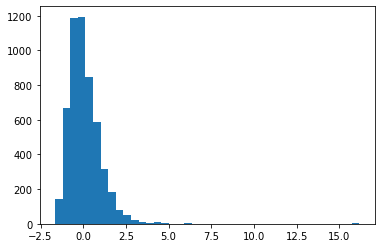

In [19]:
plt.hist(X.LSCP_score, bins=40)

In [198]:
'''from scipy.stats import gaussian_kde
g = gaussian_kde(X.LSCP_score) # here I use the LSCP scores for all samples
f = g.evaluate(X.LSCP_score) # I use that to evaluate all the scores
X['prob'] = list(f) # since I'm looking for the rare cases, I take the rarer ones as being higher probability
'''


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [235]:
from scipy.stats import norm
X['prob'] = norm.cdf(X.LSCP_score)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [218]:
X['prob'] = X.apply(lambda x: x['prob'] if x['LSCPadj']!=-1 else 0, axis=1)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [219]:
checker = X[['wallet','LSCP_score','LSCP', 'LSCPadj','prob']]

In [220]:
checker.loc[:100,:]

,wallet,LSCP_score,LSCP,LSCPadj,prob
0,0x000000000c7c9cbb8485c5e38c6c0da6a1017c1f,0.931822,0,0,0.824286
1,0x000000043dc3052d771845a71efc05b67f40abb4,-0.578138,0,0,0.281585
2,0x00083c3ae5730507fa39a90220df704c09cf124d,0.040648,0,0,0.516212
3,0x000e4b8d275cbe6af5c01a73bab484282317d8bb,1.794154,1,-1,0.000000
4,0x00101a0e98ecea02681a5447c3cab0c787d109f6,0.032456,0,0,0.512946
5,0x0010eb837063ab66d2179887e84402cda8c6baea,-0.548492,0,0,0.291677
6,0x00133dcda2946722de0f25e6ecfab53d12a06062,-0.023146,0,0,0.490767
7,0x0017ceed8eb8fc7977c55dce6b0dc3ffe8f4d184,-0.433736,0,0,0.332240
8,0x002b5274208de2c4efea9382558884d9ef97d557,-0.984301,0,0,0.162484
9,0x002bfafd32dc18c6588b704139b2fa495acab529,0.167519,0,0,0.566519


(array([270., 637., 638., 684., 625., 546., 482., 422., 392., 348.]),
 array([0.04915371, 0.13960516, 0.23005661, 0.32050806, 0.41095951,
        0.50141096, 0.59186241, 0.68231386, 0.77276531, 0.86321676,
        0.95366821]),
 <BarContainer object of 10 artists>)

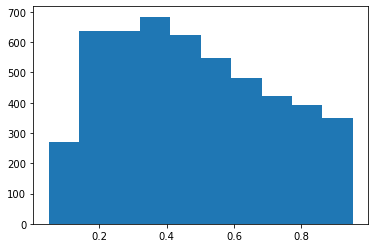

In [215]:
plt.hist(checker[checker.LSCP==0].prob2)

(array([ 4.,  6.,  2.,  6.,  5.,  2.,  3., 13.,  9., 15.]),
 array([0.95440304, 0.95896274, 0.96352243, 0.96808213, 0.97264183,
        0.97720152, 0.98176122, 0.98632091, 0.99088061, 0.9954403 ,
        1.        ]),
 <BarContainer object of 10 artists>)

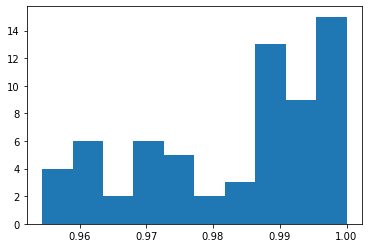

In [216]:
plt.hist(checker[checker.LSCPadj==1].prob2)

In [236]:
X.columns

Index(['wallet', 'unique_nodes', 'avgAuditReputation', 'avgFreeDisk',
       'maxPieceCount', 'numAssocWallets', 'numAssocEmails', 'avgMonthPay',
       'numOutbound', 'tokenTypes', 'numInbound', 'numAssoc', 'marchShift',
       'uniqOutboundProp', 'uniqInboundProp', 'avgPayPerNode', 'daysInService',
       'relPieceToPay', 'LSCP', 'LSCPadj', 'LSCP_score', 'prob'],
      dtype='object')

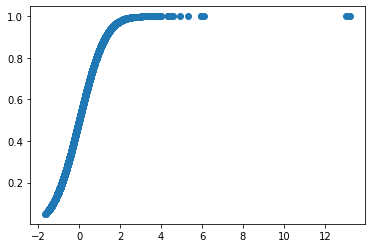

In [238]:
plt.scatter(X.LSCP_score, X.prob)

In [224]:
X.drop(columns=['prob2','LSCP2'],inplace=True)
X[X.LSCPadj==1].to_pickle('candidateDF2.pkl')

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [2]:
#Save a csv version
X[X.LSCPadj==1].to_csv('clustering_candidate65.csv')

In [239]:
X[['wallet','LSCP_score','avgMonthPay','prob']].to_csv('LSCPoutputFinal.csv')

**Post-modeling analysis**

In [1]:
import pandas as pd, numpy as np
candidateDF2.loc[0,:] = pd.read_pickle('candidateDF2.pkl')
data = pd.read_pickle('operatorDataTx.pkl')

In [62]:
data.columns

Index(['wallet', 'unique_nodes', 'minAuditReputation', 'avgAuditReputation',
       'maxAuditReputation', 'minFreeDisk', 'avgFreeDisk', 'maxFreeDisk',
       'minPieceCount', 'avgPieceCount', 'maxPieceCount',
       'earliestNodeCreated', 'mostRecentNodeCreated', 'fullWalletList',
       'fullEmailList', 'numAssocWallets', 'numAssocEmails', '2020-02-01',
       '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
       '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', 'sixMonthPay',
       'avgMonthPay', 'numOutbound', 'uniqueOutbound', 'tokenTypes',
       'numInbound', 'uniqueInbound', 'associatesTo', 'associatesFrom',
       'associates', 'numAssoc', 'type_eth', 'type_zksync'],
      dtype='object')

In [35]:
#one-hot encode the type column
onehot_types = pd.get_dummies(data['type'], prefix='type')
data = data.drop('type',axis=1).merge(onehot_types,left_index=True, right_index=True)

In [48]:
def monthlyPay(row):
    colz = ['2020-02-01',
       '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
       '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01']
    for z in range(len(colz)):
        print(colz[z],': ',round(data.loc[row,:][colz[z]],2))


In [63]:
wallets = candidateDF2.wallet
storjWallet = '0xb64ef51c888972c908cfacf59b47c1afbc0ab8ac'
B = data[data.wallet.isin(wallets)]
counter = 1
for index,row in B.iterrows():
    print(counter)
    print('wallet: ',row.wallet)
    print('number of nodes: ',row.unique_nodes)
    print('average audit reputation across nodes: ',row.avgAuditReputation)
    print('average monthly earnings: ',round(row.avgMonthPay,2))
    print('6 month earnings: ', round(row.sixMonthPay, 2))
    print('monthly earnings history: ')
    monthlyPay(index)
    print('The max piece count for any node operated by this wallet: ',"{:,}".format(round(row.maxPieceCount)))
    print('number of wallets: ',row.numAssocWallets)
    print('number of emails: ',row.numAssocEmails)
    print('active since: ', row.earliestNodeCreated)
    print('number of transactions outbound: ',row.numOutbound)
    print('number of transaction inbound: ',row.numInbound)
    print('number of unique wallets transferred to: ',row.uniqueOutbound)
    print('nuber of unique wallets received transfers from: ',row.uniqueInbound)
    print('number of tokens types transacted in: ',row.tokenTypes)
    if row.type_zksync==1:
        print('This is a zksync wallet')
    secondWallet=[]
    if row.numAssocWallets>1:
        option = [p for p in row.fullWalletList if p != row.wallet]
        extraWallet = option[0]
        print('\n')
        print('Another wallet has received payments for nodes associated with this wallet.')
        print('Details of the second wallet: ')
        print(extraWallet)
        print(data[data.wallet==extraWallet].reset_index().loc[0,'unique_nodes'], ' nodes, ',
         round(data[data.wallet==extraWallet].reset_index().loc[0,'avgMonthPay'],2), ' average monthly earnings, ', 
              round(data[data.wallet==extraWallet].reset_index().loc[0,'sixMonthPay'],2), ' six month earnings, ',
             data[data.wallet==extraWallet].reset_index().loc[0,'earliestNodeCreated'], ' first active.')
        if extraWallet in list(candidateDF2.wallet):
            print('**This extra wallet was also detected as an outlier')
        secondWallet.append(extraWallet)
        #emailList = [y for y in data[data.wallet==i].fullEmailList]
    masterEmail = [z for z in row.fullEmailList]
    colleagues =[]
    associates = [x for x in row.associates]
    if storjWallet in associates:
        associates = list(filter((storjWallet).__ne__, associates))
        #associates.remove(storjWallet)
    if len(secondWallet)>0:
        if secondWallet[0] in associates:
            associates = list(filter((secondWallet[0]).__ne__, associates))
    print('number of known associates: ',len(associates))
    for i in associates:
        if i in list(candidateDF2.wallet):
            colleagues.append(i)
        info = data[data.wallet==i].reset_index(drop=True)
        print('\n')
        print('associate details: ')
        print(i)
        print(data[data.wallet==i].reset_index().loc[0,'unique_nodes'], ' nodes, ',
         round(data[data.wallet==i].reset_index().loc[0,'avgMonthPay'],2), ' average monthly earnings, ', 
              round(data[data.wallet==i].reset_index().loc[0,'sixMonthPay'],2), ' six month earnings, ',
             data[data.wallet==i].reset_index().loc[0,'earliestNodeCreated'], ' first active.')
        emailList = [y for y in data[data.wallet==i].fullEmailList]
        if len(emailList)>0:
            emailList=emailList[0]
        switch = 0
        for j in emailList:
            if j in masterEmail:
                switch=1
        if switch == 1:
            print('**The above associate shares a common email address with the candidate')
        if i in colleagues:
            print('**The above associate was also detected as an outlier')
    counter+=1
    print('----------------------------------------')
    
    
    
    

1
wallet:  0x08b4bd6fc28d2cf2f174507495a6abac4a27d7ce
number of nodes:  1.0
average audit reputation across nodes:  1.0
average monthly earnings:  19.27
6 month earnings:  38.53
monthly earnings history: 
2020-02-01 :  0.0
2020-03-01 :  0.0
2020-04-01 :  0.0
2020-05-01 :  0.0
2020-06-01 :  0.12
2020-07-01 :  0.29
2020-08-01 :  1.47
2020-09-01 :  2.56
2020-10-01 :  2.45
2020-11-01 :  8.75
2020-12-01 :  0.0
2021-01-01 :  0.0
2021-02-01 :  29.78
2021-03-01 :  0.0
2021-04-01 :  0.0
The max piece count for any node operated by this wallet:  8,062
number of wallets:  1.0
number of emails:  1.0
active since:  2020-06-09
number of transactions outbound:  11
number of transaction inbound:  9
number of unique wallets transferred to:  5
nuber of unique wallets received transfers from:  5
number of tokens types transacted in:  2
number of known associates:  1


associate details: 
0xa29ac1b67e24209572473f90ee8857314e8c476b
3.0  nodes,  6.53  average monthly earnings,  13.05  six month earnings,  2

3.0  nodes,  6.67  average monthly earnings,  6.67  six month earnings,  2020-04-28  first active.
**The above associate shares a common email address with the candidate


associate details: 
0xddd3184142dc52fb637fb605b0d811a5ceaea0ca
1.0  nodes,  5.17  average monthly earnings,  5.17  six month earnings,  2020-07-09  first active.
----------------------------------------
14
wallet:  0x3756d9850d6f3605ab3e0666f636624a18f82e10
number of nodes:  52.0
average audit reputation across nodes:  0.99613855012392
average monthly earnings:  152.16
6 month earnings:  912.97
monthly earnings history: 
2020-02-01 :  5.88
2020-03-01 :  16.01
2020-04-01 :  14.57
2020-05-01 :  31.24
2020-06-01 :  44.73
2020-07-01 :  73.69
2020-08-01 :  103.07
2020-09-01 :  105.51
2020-10-01 :  142.51
2020-11-01 :  175.05
2020-12-01 :  129.66
2021-01-01 :  189.51
2021-02-01 :  205.12
2021-03-01 :  109.99
2021-04-01 :  103.64
The max piece count for any node operated by this wallet:  2,161,175
number of wallets:  1.0
nu

2020-11-01 :  20.93
2020-12-01 :  25.4
2021-01-01 :  52.34
2021-02-01 :  0.0
2021-03-01 :  0.0
2021-04-01 :  0.0
The max piece count for any node operated by this wallet:  919,823
number of wallets:  1.0
number of emails:  11.0
active since:  2019-09-18
number of transactions outbound:  80
number of transaction inbound:  0
number of unique wallets transferred to:  9
nuber of unique wallets received transfers from:  0
number of tokens types transacted in:  1
number of known associates:  0
----------------------------------------
26
wallet:  0x650efbd5cf60eff44cad1999abdf3aabf7fef77d
number of nodes:  43.0
average audit reputation across nodes:  0.9921245438238895
average monthly earnings:  101.51
6 month earnings:  609.08
monthly earnings history: 
2020-02-01 :  3.68
2020-03-01 :  10.57
2020-04-01 :  13.24
2020-05-01 :  18.79
2020-06-01 :  30.48
2020-07-01 :  51.89
2020-08-01 :  68.95
2020-09-01 :  76.49
2020-10-01 :  94.42
2020-11-01 :  118.58
2020-12-01 :  85.21
2021-01-01 :  117.77
2

35
wallet:  0x98b1f976c4f7edad1219db7cd324687618774fe0
number of nodes:  18.0
average audit reputation across nodes:  1.0
average monthly earnings:  87.25
6 month earnings:  261.74
monthly earnings history: 
2020-02-01 :  2.22
2020-03-01 :  8.33
2020-04-01 :  8.69
2020-05-01 :  7.74
2020-06-01 :  10.4
2020-07-01 :  16.03
2020-08-01 :  31.34
2020-09-01 :  31.72
2020-10-01 :  42.2
2020-11-01 :  96.54
2020-12-01 :  67.36
2021-01-01 :  97.84
2021-02-01 :  0.0
2021-03-01 :  0.0
2021-04-01 :  0.0
The max piece count for any node operated by this wallet:  11,161
number of wallets:  1.0
number of emails:  17.0
active since:  2020-01-17
number of transactions outbound:  262
number of transaction inbound:  34
number of unique wallets transferred to:  14
nuber of unique wallets received transfers from:  6
number of tokens types transacted in:  3
number of known associates:  1


associate details: 
0xd1120a772629f4184f5e10dc183837babccfd80a
22.0  nodes,  89.42  average monthly earnings,  268.27  s

monthly earnings history: 
2020-02-01 :  0.0
2020-03-01 :  0.0
2020-04-01 :  0.0
2020-05-01 :  0.0
2020-06-01 :  0.0
2020-07-01 :  0.0
2020-08-01 :  0.0
2020-09-01 :  0.0
2020-10-01 :  0.06
2020-11-01 :  1.74
2020-12-01 :  0.0
2021-01-01 :  0.0
2021-02-01 :  41.81
2021-03-01 :  27.17
2021-04-01 :  0.0
The max piece count for any node operated by this wallet:  869,503
number of wallets:  1.0
number of emails:  1.0
active since:  2020-10-01
number of transactions outbound:  211
number of transaction inbound:  30
number of unique wallets transferred to:  8
nuber of unique wallets received transfers from:  3
number of tokens types transacted in:  3
number of known associates:  0
----------------------------------------
51
wallet:  0xd887333c3acfc5f6e449b53d08c82375b54f920e
number of nodes:  21.0
average audit reputation across nodes:  0.9763273850543394
average monthly earnings:  13.33
6 month earnings:  26.66
monthly earnings history: 
2020-02-01 :  0.0
2020-03-01 :  0.0
2020-04-01 :  0.0

2021-02-01 :  165.38
2021-03-01 :  90.84
2021-04-01 :  94.9
The max piece count for any node operated by this wallet:  2,792,549
number of wallets:  1.0
number of emails:  6.0
active since:  2019-07-15
number of transactions outbound:  246
number of transaction inbound:  11
number of unique wallets transferred to:  24
nuber of unique wallets received transfers from:  3
number of tokens types transacted in:  2
number of known associates:  0
----------------------------------------


In [186]:
bingo = data[data.wallet=='0x08b4bd6fc28d2cf2f174507495a6abac4a27d7ce'].associates
associates = [x for x in bingo][0]
if storjWallet in associates:
    associates.remove(storjWallet)
colleages = []
for i in associates:
    if i in candidateDF2.wallet:
        colleagues.append(i)
    info = data[data.wallet==i]
    print('associate details: ', data[data.wallet==i].reset_index().loc[0,'unique_nodes'], ' nodes, ',
         round(data[data.wallet==i].reset_index().loc[0,'avgMonthPay'],2), ' average monthly earnings, ', 
              round(data[data.wallet==i].reset_index().loc[0,'sixMonthPay'],2), ' six month earnings, ',
             data[data.wallet==i].reset_index().loc[0,'earliestNodeCreated'], ' first active.')
    print(type(info))

associate details:  3.0  nodes,  6.53  average monthly earnings,  13.05  six month earnings,  2020-05-08  first active.
<class 'pandas.core.frame.DataFrame'>


In [175]:
data[data.wallet=='0x08b4bd6fc28d2cf2f174507495a6abac4a27d7ce'].reset_index().loc[0,'avgMonthPay']

19.2658985

In [136]:
associates = [x for x in row.associates]
    if storjWallet in associates:
        associates.remove(storjWallet)
    
    for i in associates:
        if i in candidateDF2.wallet:
            colleagues.append(i)
        print('associate details: ', data[data.wallet==i].unique_nodes,' nodes, ', 
              data[data.wallet==i].avgMonthPay, ' average monthly earnings, ', 
              data[data.wallet==i].sixMonthPay, ' six month earnings, ',
             data[data.wallet==i].earliestNodeCreated, ' first active, ')
        emailList = [y for y in data[data.wallet==i].fullEmailList]
        switch = 0
        for j in emailList:
            if j in masterEmail:
                switch=1
        if switch == 1:
            print('The above associate shares the same email address as the candidate')



,191
wallet,0x08b4bd6fc28d2cf2f174507495a6abac4a27d7ce
unique_nodes,1
minAuditReputation,1
avgAuditReputation,1
maxAuditReputation,1
minFreeDisk,7.65516e+11
avgFreeDisk,7.65516e+11
maxFreeDisk,7.65516e+11
minPieceCount,1009
avgPieceCount,5224.67


In [132]:
tiny = ['hi','low']
if 'hi' in tiny:
    tiny.remove('hi')
print(tiny)

['low']


In [131]:
for index, row in B.iterrows():
    print ('wallet: ',row.wallet)

wallet:  0x08b4bd6fc28d2cf2f174507495a6abac4a27d7ce
wallet:  0x0aba08bc2ee19c1b390efcb8ccf1ad17daed2c96
wallet:  0x0d53d36a422d3dd841ebac8508d839259ba0668f
wallet:  0x10911f3ec784dee1db1a9f7da90b7d8b935e58a0
wallet:  0x130b4f29f1ee2e65f162d77d4cd93e526dbedd7f
wallet:  0x1db7f01cf9fafcdc5b8ef93337aa9091ac731d62
wallet:  0x28593b54ec8432983839ee2addcdb4e602ae81b6
wallet:  0x28875447e04ad0169a4f52bd8e1f3ed880cc0833
wallet:  0x28b7234d7a245bce15f0fbceb34d8d790b34be88
wallet:  0x2923be587904f3034ffab36c86c495df3c21bc97
wallet:  0x29ab00ccf1aedb576773d8846cd9cf8e14b28fa0
wallet:  0x2eea07efe6cbb9493667c289ff1eebf66317648e
wallet:  0x310f218b37d72eed03f77058a15babbfd0452030
wallet:  0x3756d9850d6f3605ab3e0666f636624a18f82e10
wallet:  0x37c611913ac8a0f3004e3180606720bf186588d6
wallet:  0x388529497a4dabf1a0f581a28ed85e2718f0915f
wallet:  0x3c0da17b90323897e54d5732a72ae5f348ed7e99
wallet:  0x42e05dc97e7baf3e1ecaaa657f2a8c479038d81b
wallet:  0x46e1f8025c2ca45145a6088963e4ac3557581d6c
wallet:  0x4

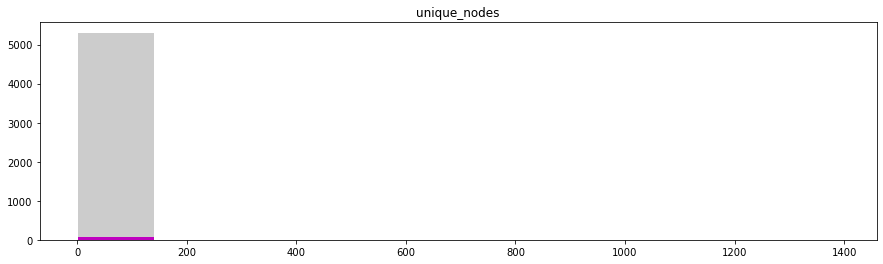

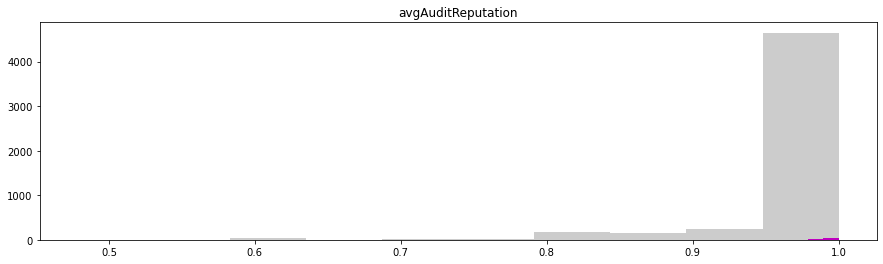

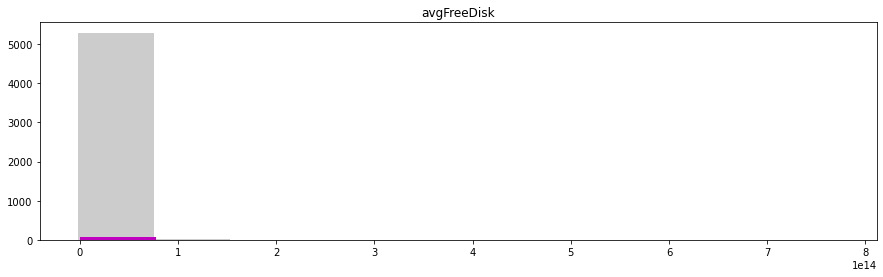

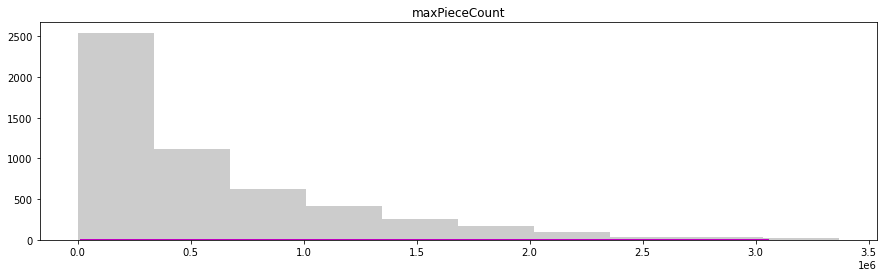

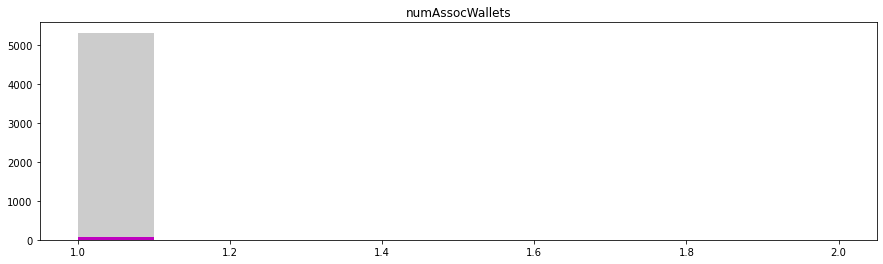

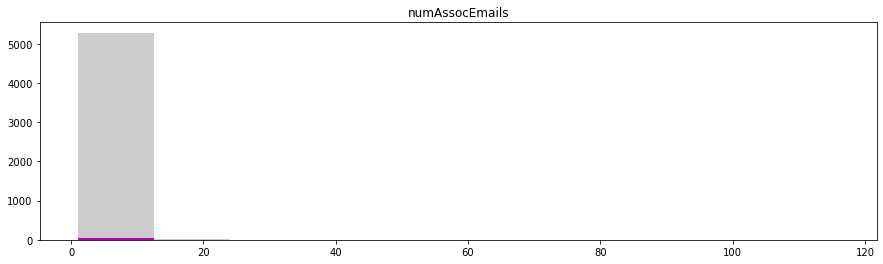

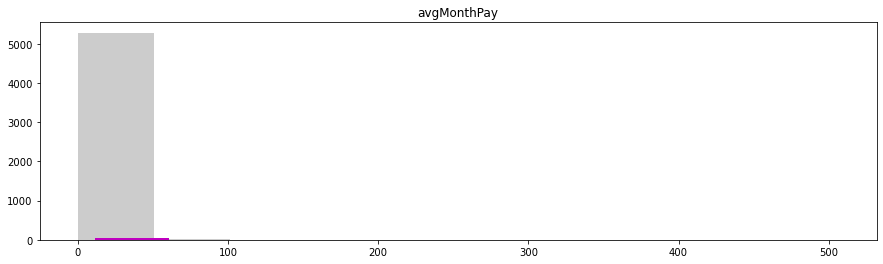

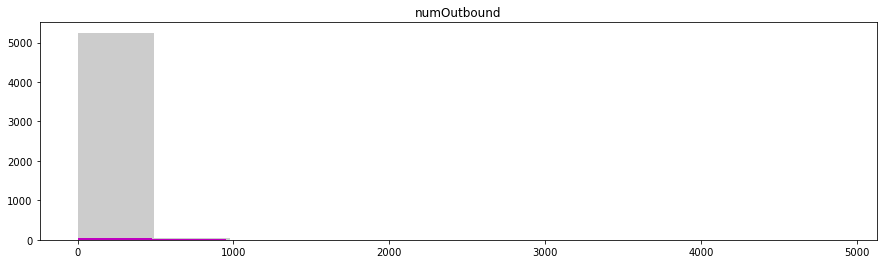

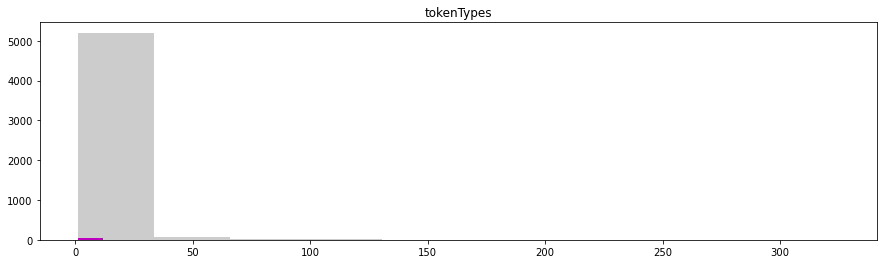

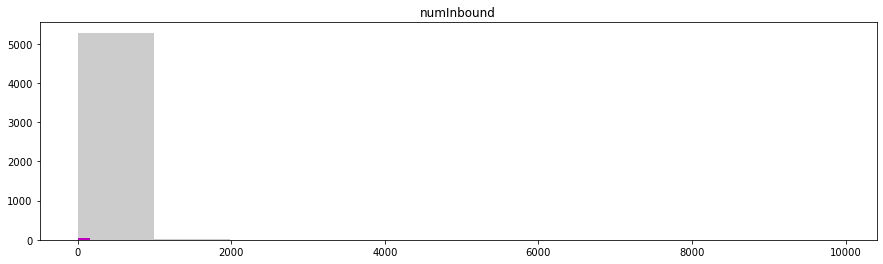

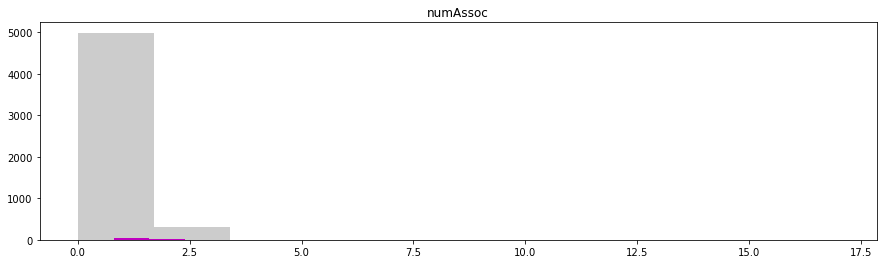

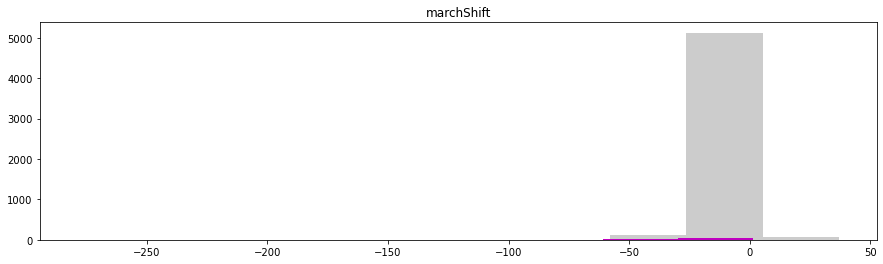

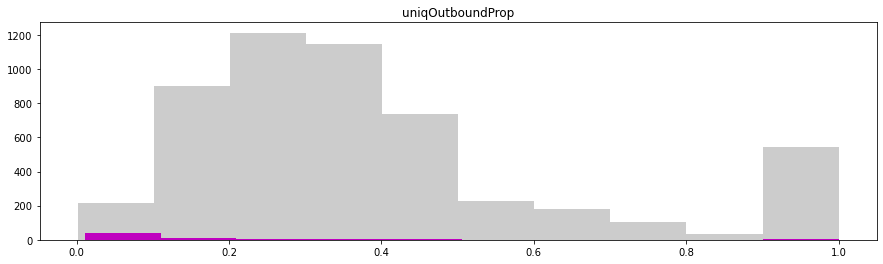

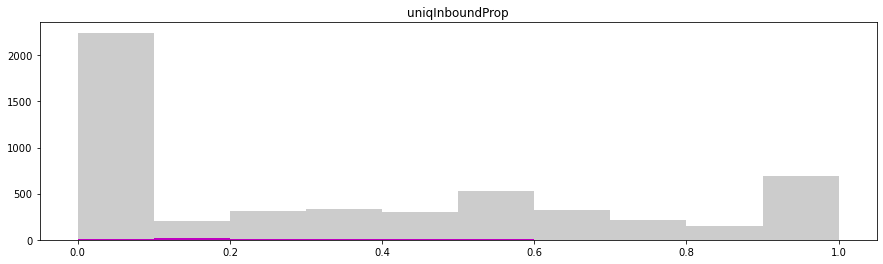

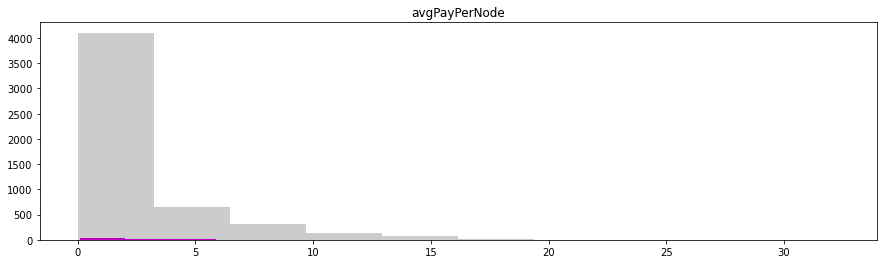

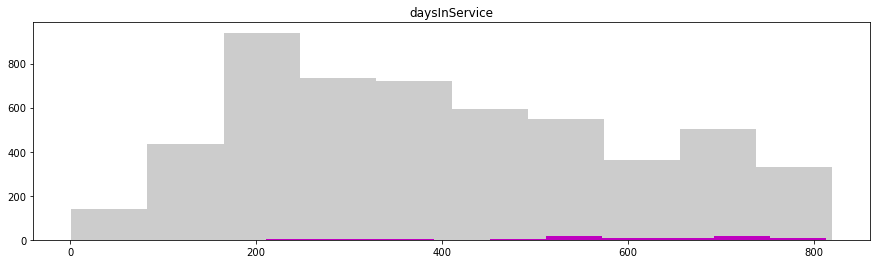

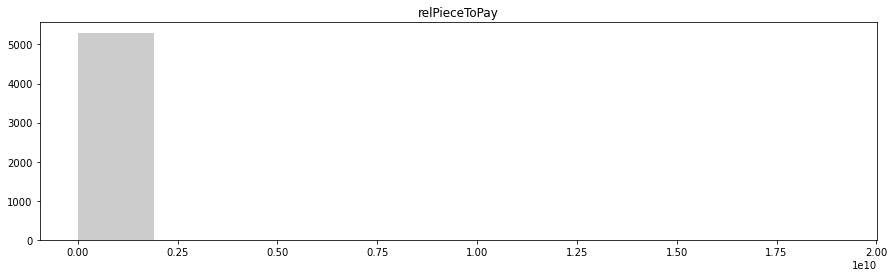

In [103]:
#View where these candidates sit in relation to the rest of the data points
for col in cols1[1:]:
    try:      
        plt.figure(figsize=(15,4))
        ax2 = plt.hist(data[col],color='0.8')
        ax1 = plt.hist(candidateDF2[col], color='m')
        plt.title(col)
        plt.show()
    except ValueError:
        print('This column can not be represented as a histogram')

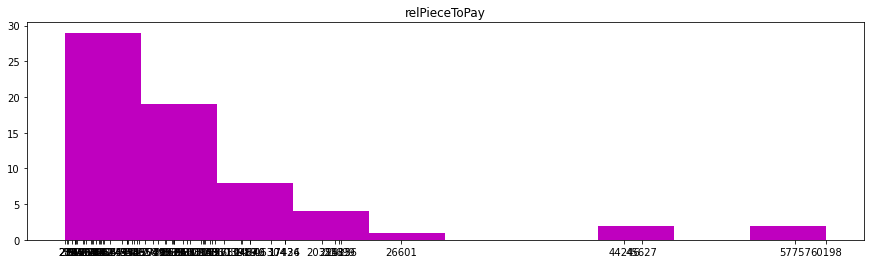

In [113]:
plt.figure(figsize=(15,4))
col=cols1[-1]
#ax2 = plt.hist(data[col],color='0.8')
ax1 = plt.hist(candidateDF2[col], color='m')
plt.xticks(candidateDF2[col])
plt.title(col)
plt.show()

In [ ]:
candidate_look = candidateDF2.sort_values(by='avgMonthPay',ascending=False)

In [ ]:
candidate_look[['wallet','associatesTo','associatesFrom']]

In [ ]:
tokenTX = pd.read_pickle('tokenTXS2.pkl')
normalTX = pd.read_csv('dfNormal.csv')

In [100]:
candidate2 = '0x310f218b37d72eed03f77058a15babbfd0452030'
lister = [x for x in data[data.wallet==candidate2].fullEmailList][0]


In [78]:
associatesX = candidateDF2[candidateDF2.wallet==candidate2].reset_index().loc[0,'associatesFrom'][1:]
associatesX

array(['0xcbd99c09dfbc0607b4d729494933a73e772f52c3',
       '0xddd3184142dc52fb637fb605b0d811a5ceaea0ca'], dtype=object)

In [92]:
print(*data[data.wallet=='0xcbd99c09dfbc0607b4d729494933a73e772f52c3'].fullEmailList)

SyntaxError: can't use starred expression here (<ipython-input-92-d1db63bf0c7b>, line 4)

In [102]:
[x for x in data[data.wallet=='0xddd3184142dc52fb637fb605b0d811a5ceaea0ca'].fullEmailList if x in lister]

[]

In [83]:
data[data.wallet==candidate2].sixMonthPay

1019    228.452719
Name: sixMonthPay, dtype: float64

In [82]:
data[data.wallet.isin(associatesX)].T

,4229,4613
wallet,0xcbd99c09dfbc0607b4d729494933a73e772f52c3,0xddd3184142dc52fb637fb605b0d811a5ceaea0ca
unique_nodes,3,1
minAuditReputation,1,1
avgAuditReputation,1,1
maxAuditReputation,1,1
minFreeDisk,1.11392e+11,6.19093e+12
avgFreeDisk,5.74394e+12,6.19093e+12
maxFreeDisk,8.73031e+12,6.19093e+12
minPieceCount,1928,342275
avgPieceCount,31576.7,762123


In [ ]:
associates1 = candidate_look[['wallet','associatesTo','associatesFrom']].reset_index(drop=True).loc[0,'associatesFrom']
associates1

In [ ]:
print(*normalTX[(tokenTX.to=='0x8cbb890bbcdc4c0788c2017cce1eebb7b2c449c2')&(tokenTX['from']=='0xb8f34dc4cac18d5f53a70c02308a29fe2436060b')].reset_index().loc[0:3,'hash'])

In [ ]:
# $18 received in 2019 from one associate
18446834400/1000000000

In [ ]:
p1='0x8cbb890bbcdc4c0788c2017cce1eebb7b2c449c2'
p2='0xb8f34dc4cac18d5f53a70c02308a29fe2436060b'

In [56]:
candidateDF2[candidateDF2.wallet=='0xddd3184142dc52fb637fb605b0d811a5ceaea0ca']

,wallet,unique_nodes,minAuditReputation,avgAuditReputation,maxAuditReputation,minFreeDisk,avgFreeDisk,maxFreeDisk,minPieceCount,avgPieceCount,...,OCSVM,OCSVM_score,ISOFOREST,ISOFOREST_score,COPOD,COPOD_score,LSCP,LSCPadj,LSCP_score,prob


In [ ]:
print(*data[data.wallet=='0xb8f34dc4cac18d5f53a70c02308a29fe2436060b'].loc[:,'associates'])

In [ ]:
lister = list(candidateDF2[candidateDF2.wallet==p1].fullEmailList)
lister2 = list(candidateDF2[candidateDF2.wallet==p2].fullEmailList)
print(lister)
print(lister2)


In [ ]:
candidateDF2[candidateDF2.wallet==p1].T

In [ ]:
candidateDF2[candidateDF2.wallet=='0xb8f34dc4cac18d5f53a70c02308a29fe2436060b'].T

In [ ]:
allNodes = pd.read_csv('allNodes.csv')
p2nodes = allNodes[allNodes.wallet=='0xb8f34dc4cac18d5f53a70c02308a29fe2436060b']
p1nodes

In [ ]:
allPayments = pd.read_csv('allPayReceipts.csv')
p2Pay = allPayments[allPayments.node_id.isin(p2nodes.id)]
p2Pay

In [ ]:
allPayments.columns

In [ ]:
#What's the average pay per node?
plt.hist((data.avgMonthPay/data.unique_nodes),bins=40)
plt.xlabel('average monthly pay, in Storj, per node operated')
plt.ylabel('number of operators receiving this rate')
plt.axvline((data.avgMonthPay/data.unique_nodes).mean(), color='g', linestyle='dashed', linewidth=1)
plt.axvline((data.avgMonthPay/data.unique_nodes).max(), color='m', linestyle='dashed', linewidth=1)

In [ ]:
(data.avgMonthPay/data.unique_nodes).max()

In [ ]:
plt.hist((candidateDF2.avgMonthPay/candidateDF2.unique_nodes),bins=40)

In [ ]:
candidateDF2['avgPayPerNode']=candidateDF2.apply(lambda x: x['avgMonthPay']/x['unique_nodes'],axis=1)

In [ ]:

data[data.avgPayPerNode>32].T

In [ ]:
candidateDF2[candidateDF2.avgPayPerNode>14].avgMonthPay

In [ ]:
data[data.wallet=='0x59d0628a44f02b56b9d02b36fd2948fe595cf694'].avgPayPerNode

In [ ]:
#So the first candidate is associated with another wallet in our list of outliers, but the other wallet (active since 2019) only
#ever got paid very tiny amounts of Storj per month (so small that the adjusted amount is listed at 0) until April,
#when it suddenly got 14 Storj tokens. I've confirmed that they share an email_hash, so we can consider them the
#same person. First candidate has earned 3145 Storj tokens over the last 6 months. They have 180 nodes in one account,
#10 in the other. They've conducted large amounts of transactions in 11 different token types. 
#The average earning per node per month is 2.18 Storj, so we should expect this user to have about 392 Storj/month
#in earnings. They have an avg of 506. Their email hashes aren't associated with any user account.

In [ ]:
#check to see if they have matching emails

In [ ]:
nodeWallet = pd.read_pickle('node_level_MasterSet.pkl')

In [ ]:
nodeWallet.columns

In [57]:
candidateDF2[candidateDF2.prob<.9].prob

0     0.718821
13    0.838887
23    0.859252
38    0.839767
45    0.821368
46    0.829659
Name: prob, dtype: float64

In [61]:
candidateDF2[['wallet','prob']].to_csv('clusterCandidateProbs.csv')